# `fredpy` Examples

In [1]:
import pandas as pd
import numpy as np
import fredpy as fp
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

## Load API key

First apply for an API key for FRED here: https://research.stlouisfed.org/docs/api/api_key.html. The API key is a 32 character string that is required for making requests from FRED. Save your API key in the `fp` namespace by either setting the `fp.api_key` directly:

In [2]:
fp.api_key = '################################'

or by reading from a text file containing only the text of the API key in the first line:

In [3]:
fp.api_key = fp.load_api_key('fred_api_key.txt')

If `fred_api_key.txt` is not in the same directory as your program file, then you must supply the full path of the file. 

## Preliminary example

Downloading and plotting unemployment rate data for the US is easy with `fredpy`:

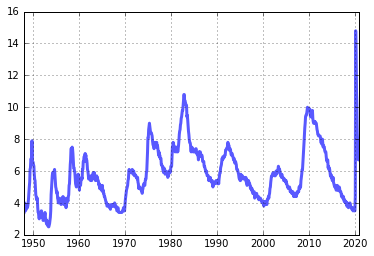

In [4]:
u = fp.series('UNRATE')
plt.plot(u.data.index,u.data.values,'-',lw=3,alpha = 0.65)
plt.grid()

In [5]:
# Download quarterly real GDP data using `fredpy`. Save the data in a variable called gdp
gdp = fp.series('gdpc1')

# Note that gdp is an instance of the `fredpy.series` class
print(type(gdp))

<class 'fredpy.series'>


In [6]:
# Print the title, the units, the frequency, the date range, and the source of the gdp data
print(gdp.title)
print(gdp.units)
print(gdp.frequency)
print(gdp.date_range)
print(gdp.source)

Real Gross Domestic Product
Billions of Chained 2012 Dollars
Quarterly
Range: 1947-01-01 to 2020-07-01
U.S. Bureau of Economic Analysis


In [7]:
# Print the last 4 values of the gdp data
print(gdp.data[-4:],'\n')

2019-10-01    19253.959
2020-01-01    19010.848
2020-04-01    17302.511
2020-07-01    18596.521
dtype: float64 



Text(0, 0.5, 'Billions of Chained 2012 Dollars')

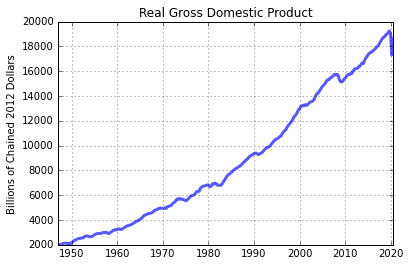

In [8]:
# Plot real GDP data
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(gdp.data,'-',lw=3,alpha = 0.65)
ax.grid()
ax.set_title(gdp.title)
ax.set_ylabel(gdp.units)

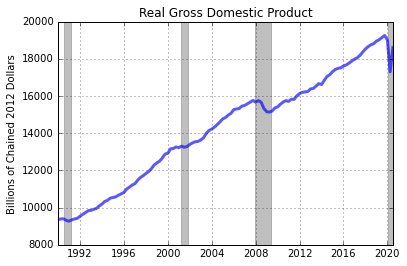

In [9]:
# Restrict GDP to observations from January 1, 1990 to present
win = ['01-01-1990','01-01-2200']
gdp_win = gdp.window(win)

# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(gdp_win.data,'-',lw=3,alpha = 0.65)
ax.grid()
ax.set_title(gdp_win.title)
ax.set_ylabel(gdp_win.units)

# Plot recession bars
gdp_win.recessions()

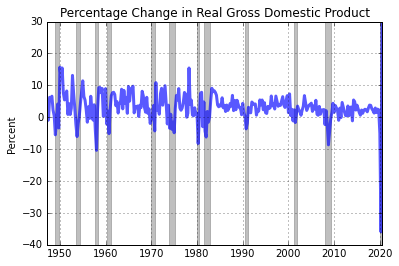

In [10]:
# Compute and plot the (annualized) quarterly growth rate of real GDP
gdp_pc = gdp.pc(annualized=True)

# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(gdp_pc.data,'-',lw=3,alpha = 0.65)
ax.grid()
ax.set_title(gdp_pc.title)
ax.set_ylabel(gdp_pc.units)

# Plot recession bars
gdp_pc.recessions()

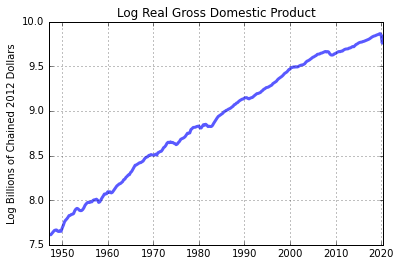

In [11]:
# Compute and plot the log of real GDP
gdp_log = gdp.log()

# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(gdp_log.data,'-',lw=3,alpha = 0.65)
ax.set_title(gdp_log.title)
ax.set_ylabel(gdp_log.units)
ax.grid()

## More examples

The following examples demonstrate some additional `fredpy` functionality.

### Comparison of CPI and GDP deflator inflation

CPI data are released monthly by the BLS while GDP deflator data are released quarterly by the BEA. Here we'll first convert the monthly CPI data to monthly frequency compute inflation as the percentage change in the respective index since on year prior.

Text(0, 0.5, 'Index 2012=100')

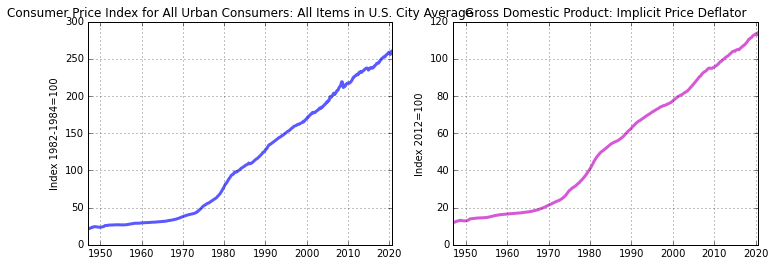

In [12]:
# Download CPI and GDP deflator data
cpi = fp.series('CPIAUCSL')
deflator = fp.series('GDPDEF')

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(cpi.data,'-',lw=3,alpha = 0.65)
ax.grid()
ax.set_title(cpi.title)
ax.set_ylabel(cpi.units)

ax = fig.add_subplot(1,2,2)
ax.plot(deflator.data,'-m',lw=3,alpha = 0.65)
ax.grid()
ax.set_title(deflator.title)
ax.set_ylabel(deflator.units)

In [13]:
# The CPI data are produced at a monthly frequency
print(cpi.frequency)

# Convert CPI data to quarterly frequency to conform with the GDP deflator
cpi_Q = cpi.as_frequency(freq='Q')
print(cpi_Q.frequency)

Monthly
Quarterly


In [14]:
# Compute the inflation rate based on each index
cpi_pi = cpi_Q.apc()
def_pi = deflator.apc()

# Print date ranges for new inflation series
print(cpi_pi.date_range)
print(def_pi.date_range)

Range: 1948-01-01 to 2020-10-01
Range: 1948-01-01 to 2020-07-01


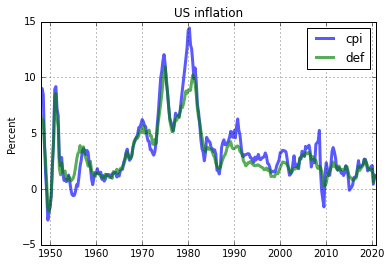

In [15]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(cpi_pi.data,'-',lw=3,alpha = 0.65,label='cpi')
ax.plot(def_pi.data,'-',lw=3,alpha = 0.65,label='def')
ax.legend(loc='upper right')
ax.set_title('US inflation')
ax.set_ylabel('Percent')
ax.grid()

Even though the CPI inflation rate is on average about .3% higher the GDP deflator inflation rate, the CPI and the GDP deflator produce comparable measures of US inflation.

In [16]:
# Download unemployment and 3 month T-bill data
unemp = fp.series('UNRATE')
tbill_3m = fp.series('TB3MS')

# Print date ranges for series
print(unemp.date_range)
print(tbill_3m.date_range)

# Equalize the date ranges
unemp, tbill_3m = fp.window_equalize([unemp, tbill_3m])

# Print the new date ranges for series
print()
print(unemp.date_range)
print(tbill_3m.date_range)

Range: 1948-01-01 to 2020-12-01
Range: 1934-01-01 to 2020-12-01

Range: 1948-01-01 to 2020-12-01
Range: 1948-01-01 to 2020-12-01


### Filtering 1: Extracting business cycle components from quarterly data with the HP filter

In [17]:
# Download nominal GDP, the GDP deflator

gdp = fp.series('GDP')
defl = fp.series('GDPDEF')

# Make sure that all series have the same window of observation
gdp,defl = fp.window_equalize([gdp,defl])

# Deflate GDP series
gdp = gdp.divide(defl)

# Convert GDP to per capita terms
gdp = gdp.per_capita()

# Take log of GDP
gdp = gdp.log()

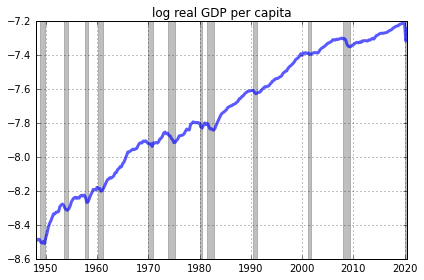

In [18]:
# Plot log data
fig = plt.figure(figsize=(6,4))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(gdp.data,'-',lw=3,alpha = 0.65)
ax1.grid()
ax1.set_title('log real GDP per capita')
gdp.recessions()

fig.tight_layout()

The post-Great Recession slowdown in US real GDP growth is apparent in the figure.

In [19]:
# Compute the hpfilter
gdp_cycle, gdp_trend = gdp.hp_filter()

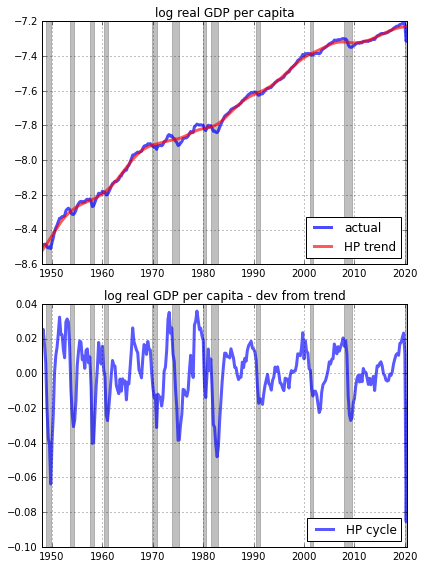

In [20]:
# Plot log data
fig = plt.figure(figsize=(6,8))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(gdp.data,'-',lw=3,alpha = 0.7,label='actual')
ax1.plot(gdp_trend.data,'r-',lw=3,alpha = 0.65,label='HP trend')
ax1.grid()
ax1.set_title('log real GDP per capita')
gdp.recessions()
ax1.legend(loc='lower right')
fig.tight_layout()

ax1 = fig.add_subplot(2,1,2)
ax1.plot(gdp_cycle.data,'b-',lw=3,alpha = 0.65,label='HP cycle')
ax1.grid()
ax1.set_title('log real GDP per capita - dev from trend')
gdp.recessions()
ax1.legend(loc='lower right')
fig.tight_layout()

### Filtering 2: Extracting business cycle components from monthly data

In Figure 1.5 from *The Conquest of American Inflation*, Thomas Sargent compares the business cycle componenets (BP filtered) of monthly inflation and unemployment data for the US from 1960-1982. Here we replicate Figure 1.5 to include the most recently available data and we also consturct the figure using HP filtered data.

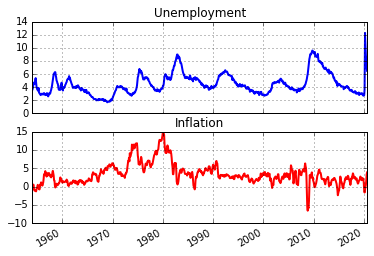

In [21]:
u = fp.series('LNS14000028')
p = fp.series('CPIAUCSL')

# Construct the inflation series
p = p.pc(annualized=True)
p = p.ma(length=6,center=True)

# Make sure that the data inflation and unemployment series cver the same time interval
p,u = fp.window_equalize([p,u])

# Data

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(u.data,'b-',lw=2)
ax.grid(True)
ax.set_title('Unemployment')

ax = fig.add_subplot(2,1,2)
ax.plot(p.data,'r-',lw=2)
ax.grid(True)
ax.set_title('Inflation')

fig.autofmt_xdate()

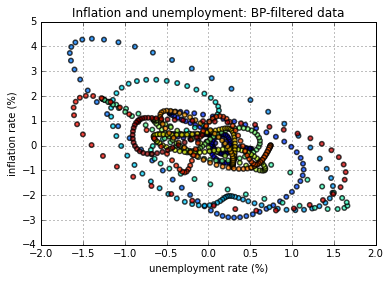

In [22]:
# Filter the data
p_bpcycle,p_bptrend = p.bp_filter(low=24,high=84,K=84)
u_bpcycle,u_bptrend = u.bp_filter(low=24,high=84,K=84)

# Scatter plot of BP-filtered inflation and unemployment data (Sargent's Figure 1.5)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
t = np.arange(len(u_bpcycle.data))
ax.scatter(u_bpcycle.data,p_bpcycle.data,facecolors='none',alpha=0.75,s=20,c=t, linewidths=1.5)
ax.set_xlabel('unemployment rate (%)')
ax.set_ylabel('inflation rate (%)')
ax.set_title('Inflation and unemployment: BP-filtered data')
ax.grid(True)

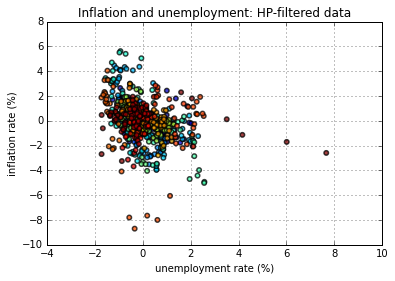

In [23]:
# HP filter
p_hpcycle,p_hptrend = p.hp_filter(lamb=129600)
u_hpcycle,u_hptrend = u.hp_filter(lamb=129600)

# Scatter plot of HP-filtered inflation and unemployment data (Sargent's Figure 1.5)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
t = np.arange(len(u_hpcycle.data))
ax.scatter(u_hpcycle.data,p_hpcycle.data,facecolors='none',alpha=0.75,s=20,c=t, linewidths=1.5)
ax.set_xlabel('unemployment rate (%)')
ax.set_ylabel('inflation rate (%)')
ax.set_title('Inflation and unemployment: HP-filtered data')
ax.grid(True)

The choice of filterning method appears to strongly influence the results. While both filtering methods 

### Vintage Data

Data are updated and ALFRED, ArchivaL Federal Reserve Economic Data, stores historical data versions. Use `get_vintage_dates()` to find the avilable vintage dates for a FRED series. For example, let's consider US GDP data.

In [64]:
# Get all available vintages
gdp_vintage_dates = fp.get_vintage_dates('GDPA')

print('Number of vintages available:',len(gdp_vintage_dates))
print('Oldest vintage:              ',gdp_vintage_dates[0])
print('Most recent vintage:         ',gdp_vintage_dates[1])

Number of vintages available: 317
Oldest vintage:               1991-12-04
Most recent vintage:          1992-01-29


From the available vintage dates, use the `observation_date` keyword in `series()` to download a desired vintage. For example, download and plot the oldest available and most recent US GDP data.

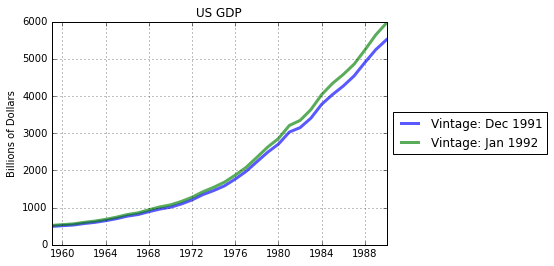

In [62]:
# Download oldest available GDP data
gdp_old = fp.series('GDPA',observation_date = gdp_vintage_dates[0])

# Download most recently available GDP data
gdp_cur = fp.series('GDPA',observation_date = gdp_vintage_dates[-1])

# Equalize date ranges
gdp_old, gdp_cur = fp.window_equalize([gdp_old, gdp_cur])


# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(gdp_old.data,lw=3,alpha = 0.65,label=pd.to_datetime(gdp_vintage_dates)[0].strftime('Vintage: %b %Y'))
ax.plot(gdp_cur.data,lw=3,alpha = 0.65,label=pd.to_datetime(gdp_vintage_dates)[1].strftime('Vintage: %b %Y'))
ax.set_ylabel(gdp_cur.units)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('US GDP')
ax.grid()

### Exporting data sets

Exporting data inported with `fredpy` to csv files is easy with `Pandas`.

In [24]:
# create a Pandas DataFrame
df = pd.DataFrame({'inflation':p.data,
                    'unemployment':u.data},)

print(df.head())

# Export to csv
df.to_csv('data.csv')

            inflation  unemployment
1954-01-01   0.300737           3.6
1954-02-01  -0.665392           3.8
1954-03-01   0.597944           4.1
1954-04-01   0.523235           4.7
1954-05-01  -0.591705           4.6
